CIFAR-10 shapes:
  x_train: (45000, 32, 32, 3)
  x_val:   (5000, 32, 32, 3)
  x_test:  (10000, 32, 32, 3)

Entrenando con beta = 1e-05
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1787 - val_loss: 0.1755
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1750 - val_loss: 0.1818
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1755 - val_loss: 0.1785
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1746 - val_loss: 0.1749
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1733 - val_loss: 0.1911
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1725 - val_loss: 0.1728
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1693 - val_loss: 0.1878
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1772 - val_loss: 0.1790
Epoch 9/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1743 - val_loss: 0.1826
Epoch 10/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1737 - val_loss: 0

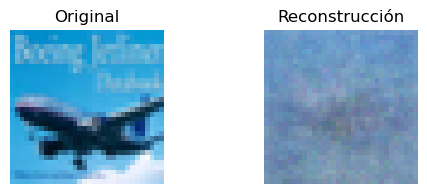

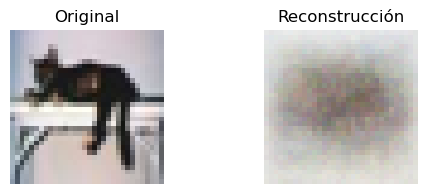

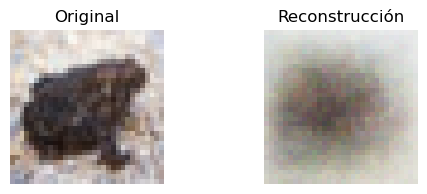


Resultados para beta = 1e-08:


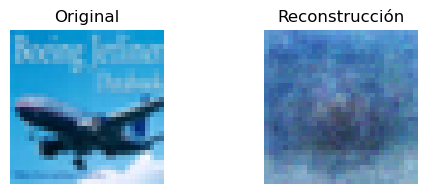

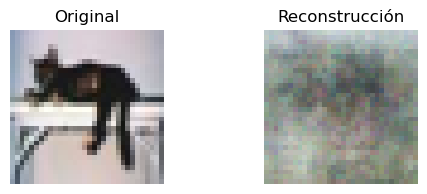

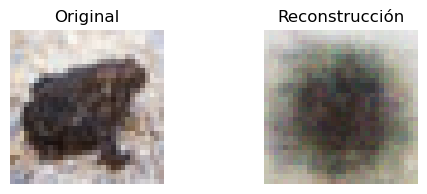


Resultados para beta = 1e-11:


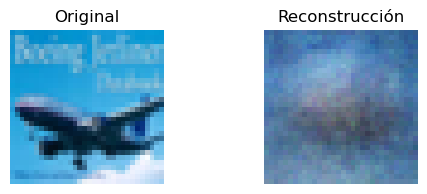

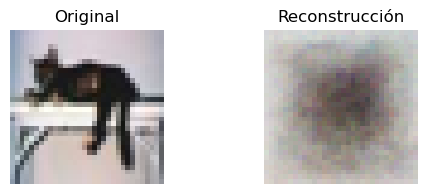

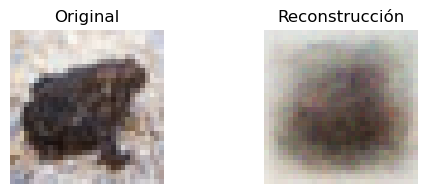

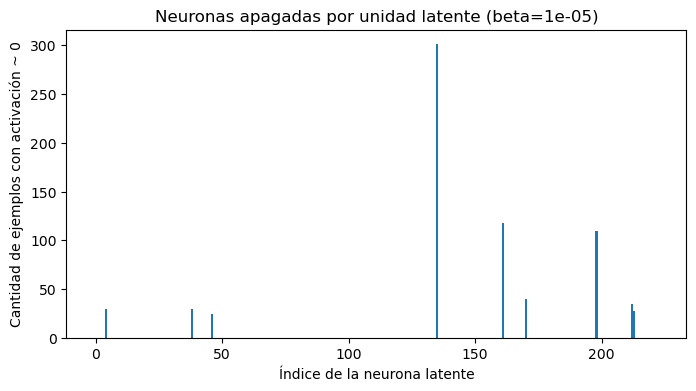

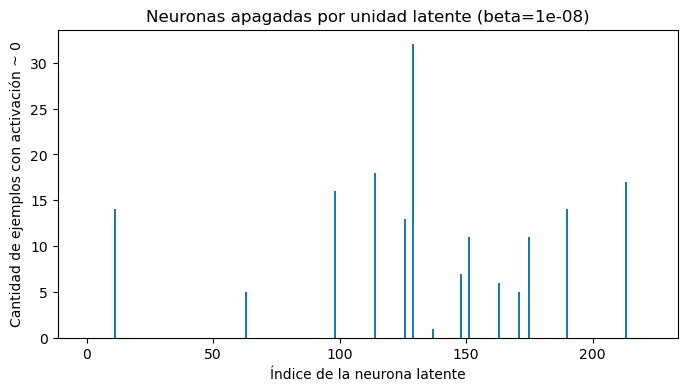

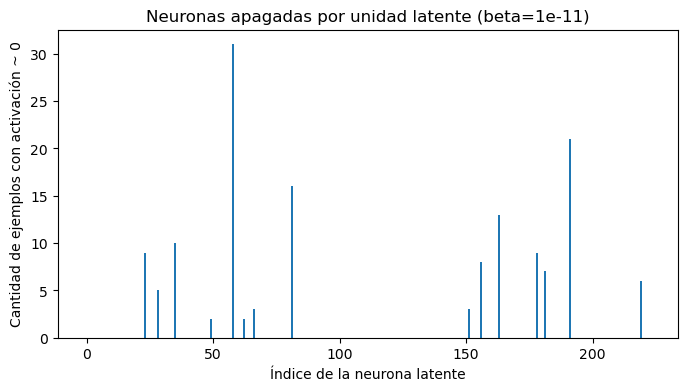

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Cargar y preparar el dataset CIFAR-10
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_val = x_train[-5000:]
x_train = x_train[:-5000]

print("CIFAR-10 shapes:")
print("  x_train:", x_train.shape)
print("  x_val:  ", x_val.shape)
print("  x_test: ", x_test.shape)

# Función para construir un autoencoder denso con regularización L1
def build_dense_autoencoder(input_shape=(32, 32, 3), latent_dim=223, units_per_layer=937, activation='tanh', learning_rate=0.003, beta=1e-5):
    # Aplanar la entrada
    input_dim = np.prod(input_shape)
    
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(units_per_layer, activation=activation)(x)

    # Capa latente con regularización L1
    latent = layers.Dense(
        latent_dim, 
        activation=activation,
        activity_regularizer=regularizers.l1(beta),
        name="latent_layer"
    )(x)

    # Decoder
    x = layers.Dense(units_per_layer, activation=activation)(latent)
    x = layers.Dense(input_dim, activation='sigmoid')(x)
    outputs = layers.Reshape(input_shape)(x)

    # Modelo
    model = tf.keras.Model(inputs, outputs, name="dense_autoencoder")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Entrenamiento y evaluación
betas = [1e-5, 1e-8, 1e-11]  # Valores de regularización inicial
EPOCHS = 10         # Más épocas para permitir un mejor entrenamiento
BATCH_SIZE = 64

num_samples = 3
indices = np.random.choice(range(x_test.shape[0]), num_samples, replace=False)
sample_images = x_test[indices]

reconstructions_dict = {}
val_mse_dict = {}
neurons_off_dict = {}

for b in betas:
    print(f"\nEntrenando con beta = {b}")
    model = build_dense_autoencoder(latent_dim=223, beta=b)
    
    history = model.fit(
        x_train, x_train,
        validation_data=(x_val, x_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # MSE de validación final
    final_val_mse = history.history['val_loss'][-1]
    val_mse_dict[b] = final_val_mse
    print(f"  -> MSE de validación (última época): {final_val_mse:.6f}")

    # Reconstrucción de las mismas muestras x_test
    reconstructions = model.predict(sample_images)
    reconstructions_dict[b] = reconstructions

    # Calcular cuántas neuronas están "apagadas" en la capa latente
    latent_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("latent_layer").output)
    latent_representations = latent_model.predict(x_train)
    neurons_off = np.sum(np.isclose(latent_representations, 0.0, atol=1e-3), axis=0)
    neurons_off_dict[b] = neurons_off
    print(f"  -> Neuronas apagadas por unidad latente (beta={b}): {neurons_off}")

# Mostrar resultados
for i, beta in enumerate(betas):
    print(f"\nResultados para beta = {beta}:")
    for j in range(num_samples):
        plt.figure(figsize=(6, 2))
        
        # Imagen original
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(sample_images[j])
        plt.axis("off")
        
        # Imagen reconstruida
        plt.subplot(1, 2, 2)
        plt.title("Reconstrucción")
        plt.imshow(reconstructions_dict[beta][j])
        plt.axis("off")

        plt.show()

# Visualizar la cantidad de neuronas apagadas por beta
for beta, neurons_off in neurons_off_dict.items():
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(neurons_off)), neurons_off)
    plt.title(f"Neuronas apagadas por unidad latente (beta={beta})")
    plt.xlabel("Índice de la neurona latente")
    plt.ylabel("Cantidad de ejemplos con activación ~ 0")
    plt.show()



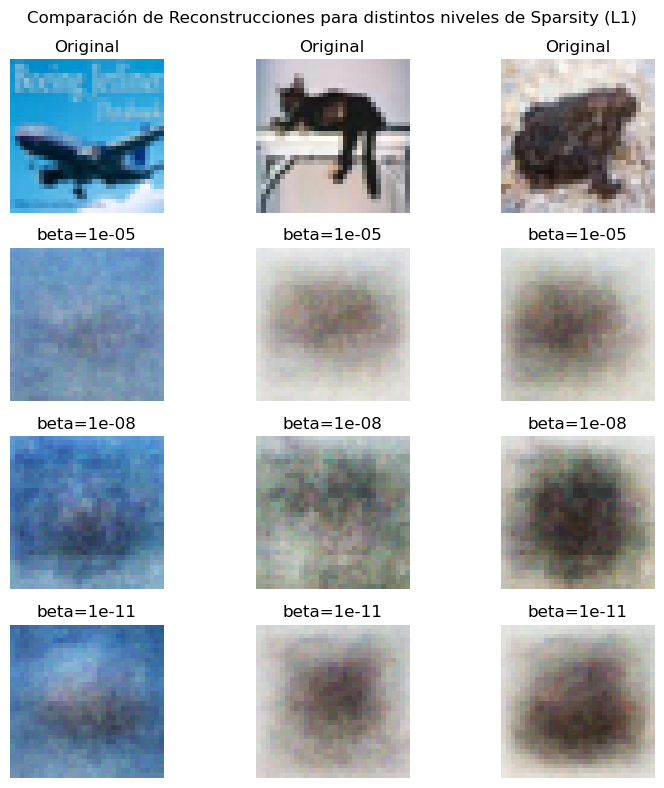


Resumen de MSE de validación por beta:
  beta=1e-05: MSE=0.177069
  beta=1e-08: MSE=0.043010
  beta=1e-11: MSE=0.041693

Mejor beta según MSE en validación: 1e-11


In [2]:
plt.figure(figsize=(8, 2 + 2 * len(betas)))

# imágenes originales
for i in range(num_samples):
    ax = plt.subplot(len(betas) + 1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

#reconstrucciones para cada beta
for row, b in enumerate(betas, start=1):
    recon = reconstructions_dict[b]
    for col in range(num_samples):
        ax = plt.subplot(len(betas) + 1, num_samples, row * num_samples + col + 1)
        plt.imshow(recon[col])
        plt.title(f"beta={b}")
        plt.axis("off")

plt.suptitle("Comparación de Reconstrucciones para distintos niveles de Sparsity (L1)")
plt.tight_layout()
plt.show()

print("\nResumen de MSE de validación por beta:")
for b, mse in val_mse_dict.items():
    print(f"  beta={b}: MSE={mse:.6f}")

best_beta = min(val_mse_dict, key=val_mse_dict.get)
print(f"\nMejor beta según MSE en validación: {best_beta}")

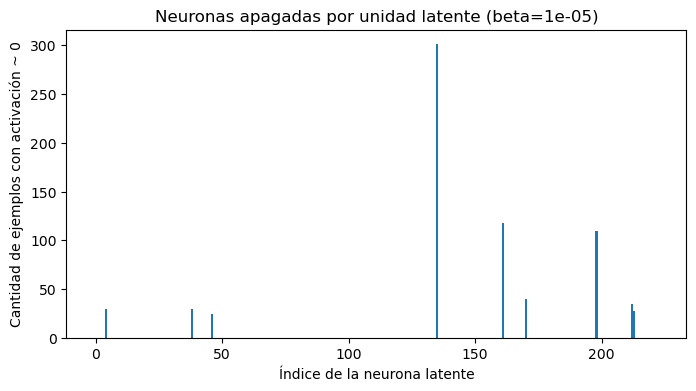

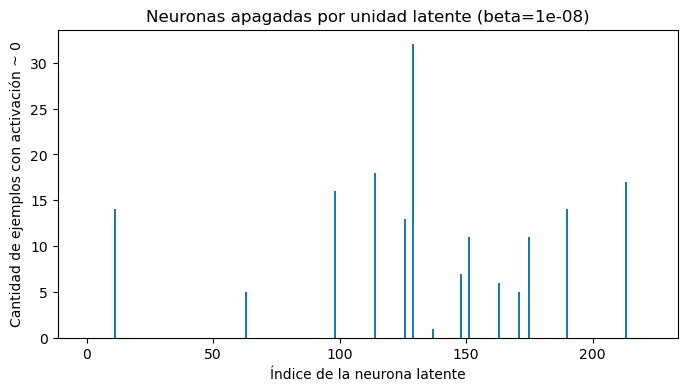

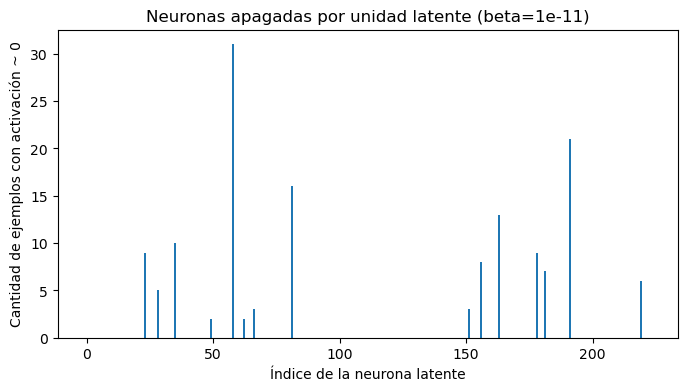

In [3]:
# Visualizar la cantidad de neuronas apagadas por beta
for beta, neurons_off in neurons_off_dict.items():
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(neurons_off)), neurons_off)
    plt.title(f"Neuronas apagadas por unidad latente (beta={beta})")
    plt.xlabel("Índice de la neurona latente")
    plt.ylabel("Cantidad de ejemplos con activación ~ 0")
    plt.show()